In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import SMOTE

# Load the Data

In [3]:
file_path = 'F:/MACHINE/winequality-red.csv'
data = pd.read_csv(file_path)

# Exploratory Data Analysis

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

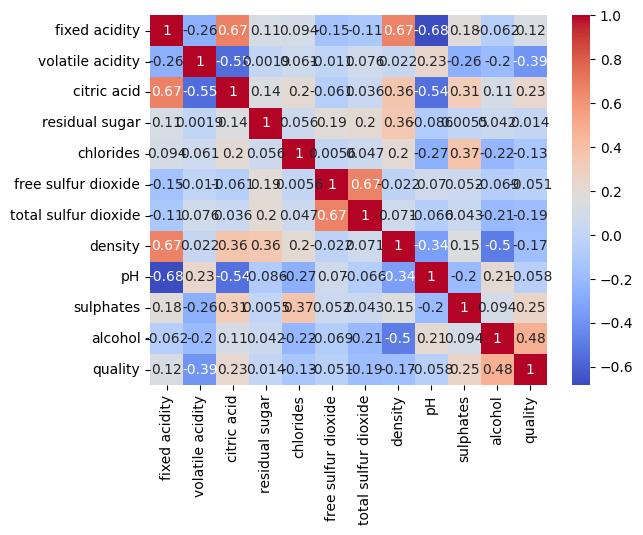

<Figure size 1600x1000 with 0 Axes>

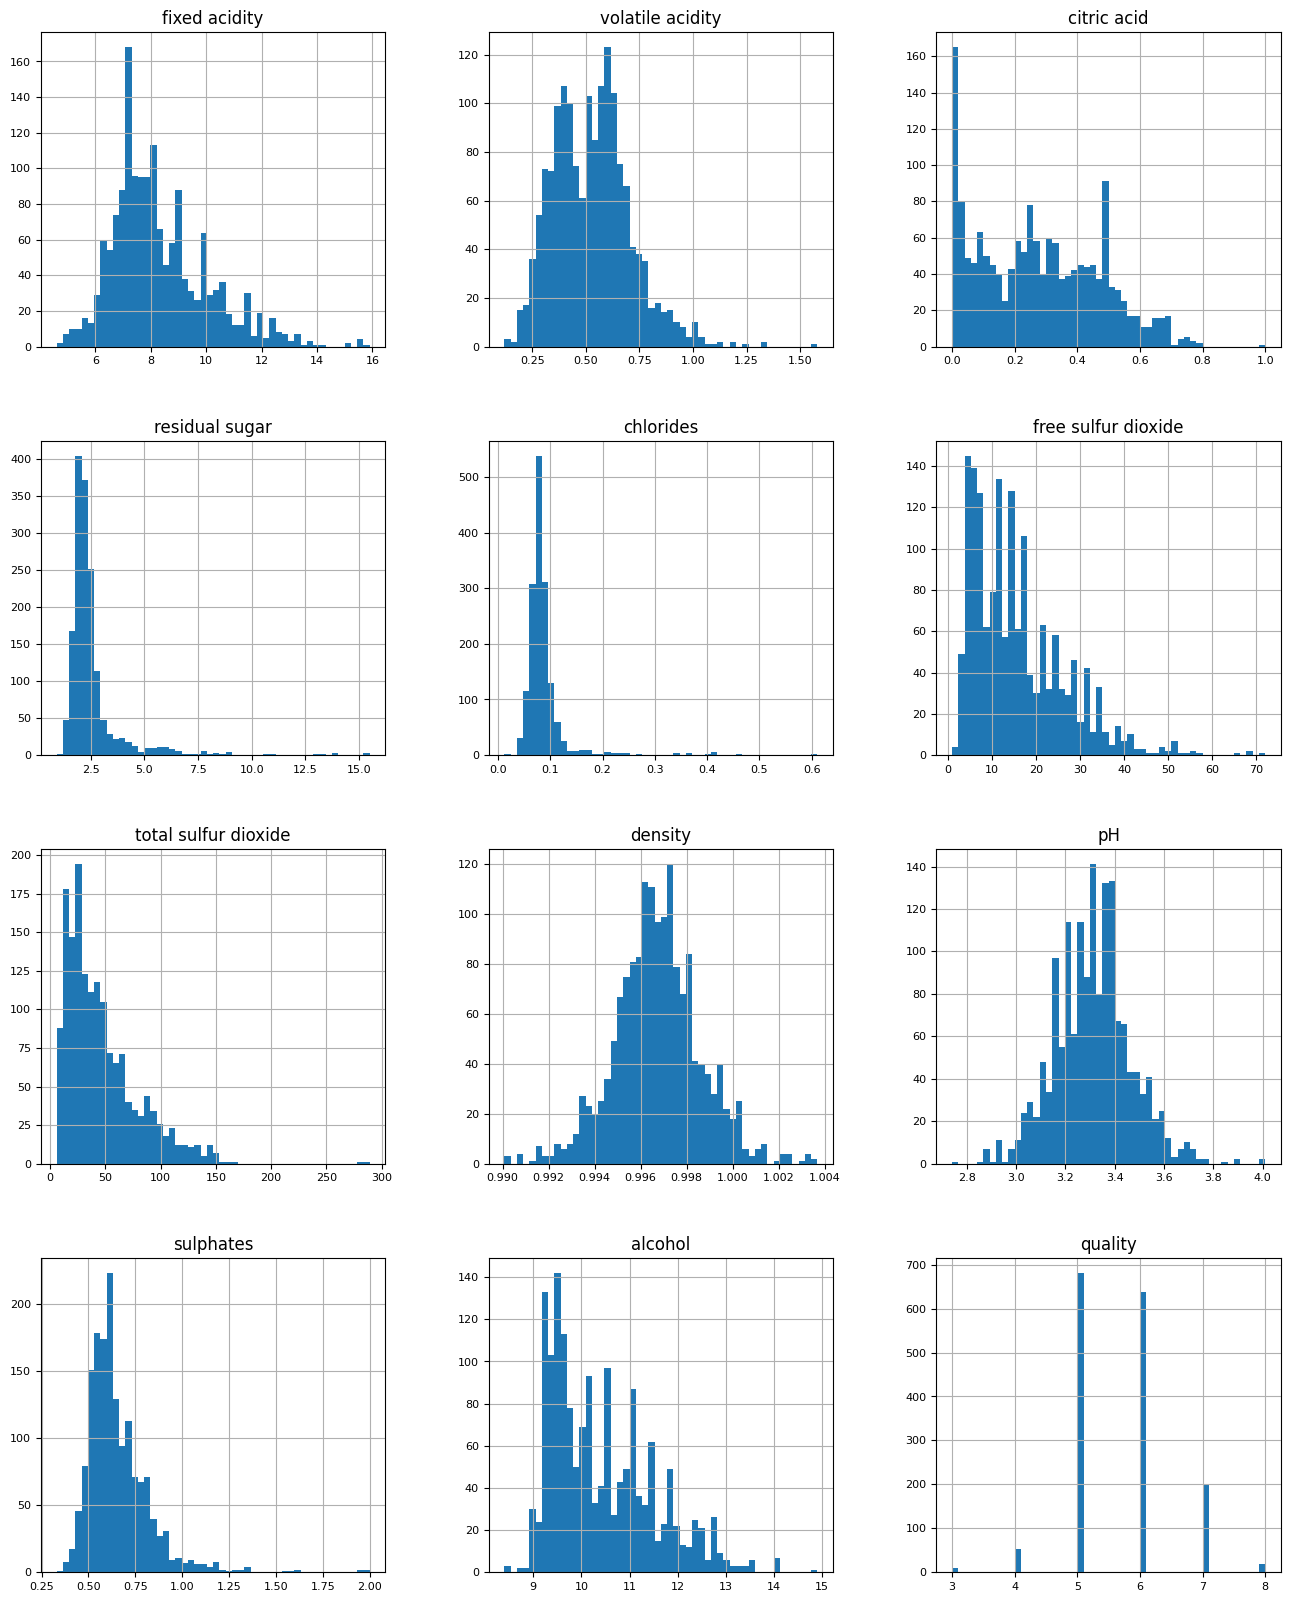

In [4]:
print(data.describe())
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.figure(figsize=(16,10))
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

# Data Preprocessing

In [5]:
print(len(data))
print(data.isnull().sum())

1599
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


# Data is complete (No null values)

In [6]:
X = data.drop('quality', axis=1)
y = data['quality']
y = y - y.min()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the ANN Model

In [8]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(512, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="tanh", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(8, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation="softmax")
])

c:\Users\Nei\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the model

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.summary()

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=300, batch_size=32, callbacks=[early_stopping, reduce_lr])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 505,250 (1.93 MB)

 Trainable params: 502,098 (1.92 MB)

 Non-trainable params: 3,152 (12.31 KB)

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1681 - loss: 2.6709 - val_accuracy: 0.5469 - val_loss: 1.8066 - learning_rate: 0.0010
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2570 - loss: 2.3274 - val_accuracy: 0.6172 - val_loss: 1.6829 - learning_rate: 0.0010
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3222 - loss: 2.2237 - val_accuracy: 0.6133 - val_loss: 1.6916 - learning_rate: 0.0010
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3917 - loss: 2.1245 - val_accuracy: 0.6484 - val_loss: 1.6078 - learning_rate: 0.0010
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4601 - loss: 2.0014 - val_accuracy: 0.6445 - val_loss: 1.5522 - learning_rate: 0.0010
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4975 - loss: 1.9357 - val_accuracy: 0.6328 - val_loss: 1.5420 - learning_rate: 0.0010
Epoch 7/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5428 - loss: 1.8375 - val_ac

# Evaluate the Model

In [10]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_acc}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6570 - loss: 1.0428 
Test Accuracy: 0.625


# Visualize output

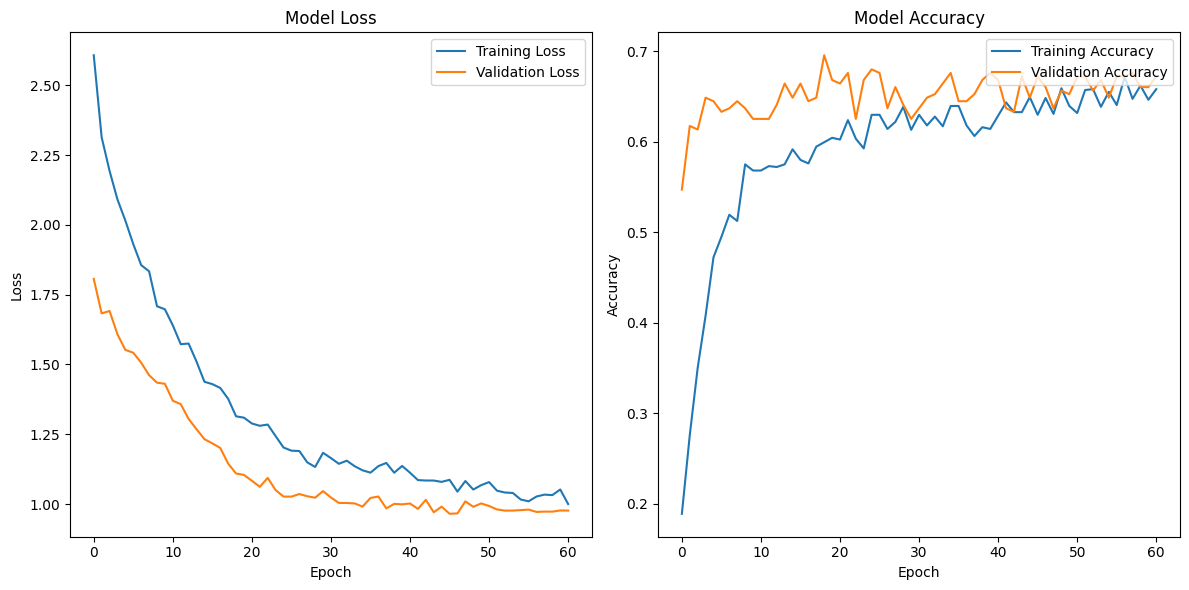

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

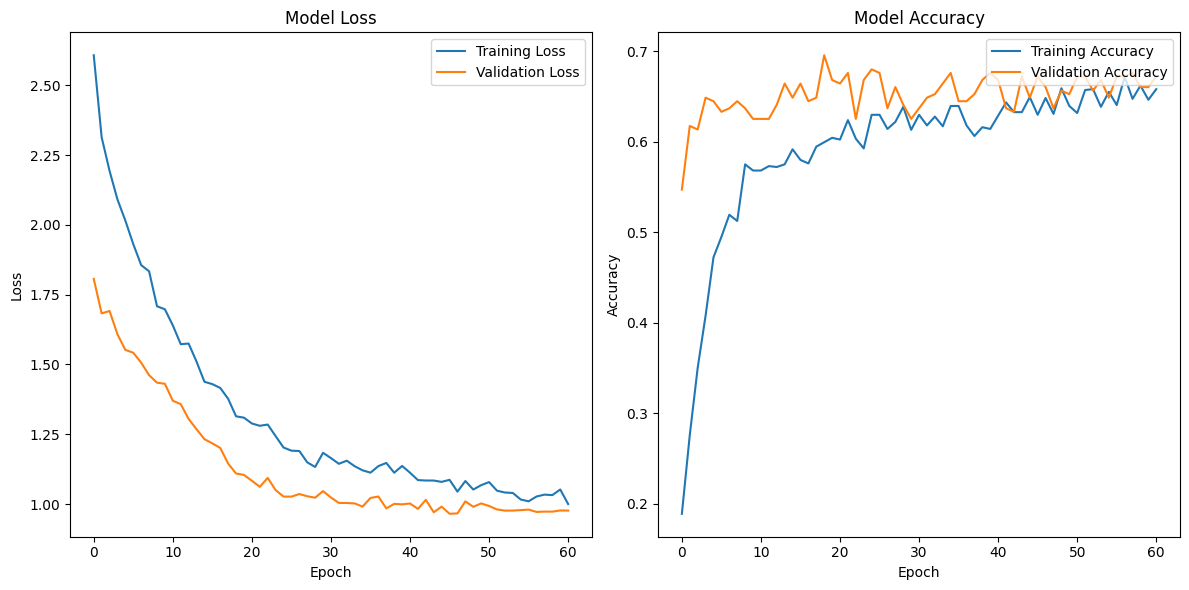

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


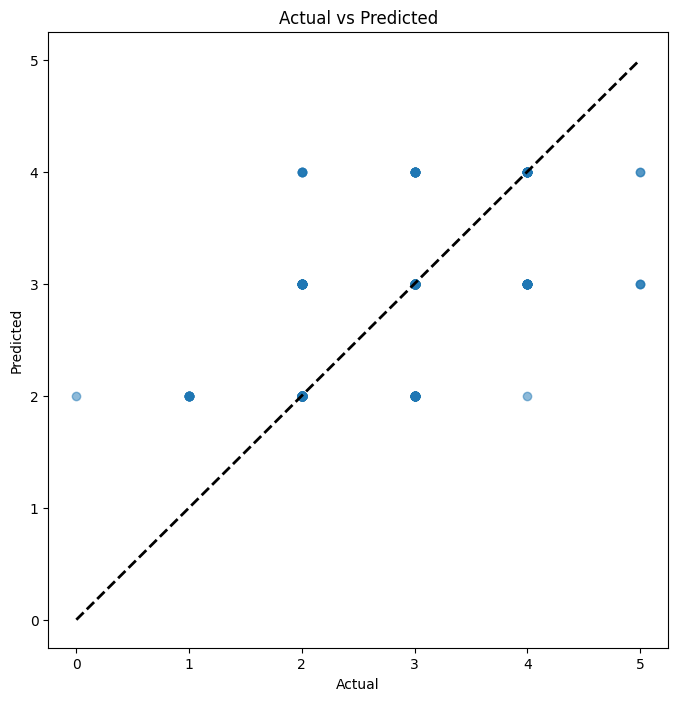

In [12]:
# Visualize output
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Predict probabilities for each class
y_pred_prob = model.predict(X_test_scaled)

# Convert probabilities to ordinal predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Compare actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Evaluate the model on the validation set

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

# Print the accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Random Forest Regressor Evaluation
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(X_train, y_train)  # Use non-scaled data for tree-based models
pred1 = regressor.predict(X_test)

# If you want to compare them directly, you might need to convert regression predictions to class labels
# For example, you can round the predictions to the nearest integer
y_pred_rounded = np.round(pred1).astype(int)
accuracy = np.mean(y_pred_rounded == y_test)
print(f'Random Forest Regressor Test Accuracy (rounded): {accuracy}')

df1 = pd.DataFrame({"Actual values": y_test, "Predicted values": y_pred_rounded})
df1

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 1.0428 
Test Accuracy: 62.50%
Random Forest Regressor Test Accuracy (rounded): 0.625


,Actual values,Predicted values
803,3,2
124,2,2
350,3,2
682,2,2
1326,3,3
...,...,...
1259,3,3
1295,2,2
1155,2,2
963,3,3


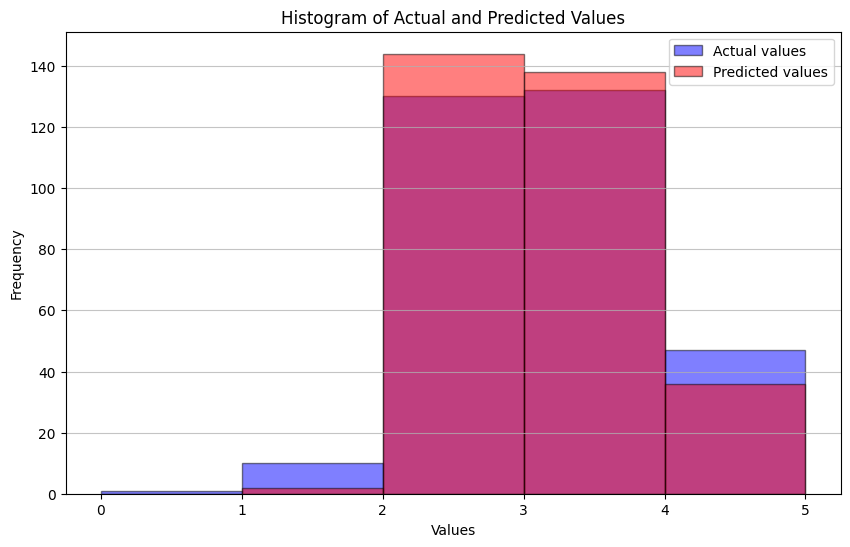

In [14]:
# Plot histograms of actual and predicted values
plt.figure(figsize=(10, 6))
bins = range(min(df1["Actual values"].min(), df1["Predicted values"].min()), max(df1["Actual values"].max(), df1["Predicted values"].max()) + 1)

plt.hist(df1["Actual values"], bins=bins, alpha=0.5, label='Actual values', color='blue', edgecolor='black')
plt.hist(df1["Predicted values"], bins=bins, alpha=0.5, label='Predicted values', color='red', edgecolor='black')

plt.title('Histogram of Actual and Predicted Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.xticks(bins)
plt.show()

In [15]:
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(X_train, y_train)  # Use non-scaled data for tree-based models
pred1= regressor.predict(X_test)
print(regressor.score(X_test,y_test))
print(mean_squared_error(y_test,pred1,squared=False))
mse = mean_squared_error(y_test, pred1, squared=False)
rmse = np.sqrt(mse)
print("Root Mean Squared Error = ", rmse)
range_y = y_test.max() - y_test.min()
rmse_percentage = (100 - (rmse / range_y) * 100)
print(f'Root Mean Squared Error as Percentage of Range: {rmse_percentage:.2f}%')

0.5196604850640327
0.5602719763650508
Root Mean Squared Error =  0.7485131771485728
Root Mean Squared Error as Percentage of Range: 85.03%


c:\Users\Nei\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Nei\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
